In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch_optimizer as optim

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exe_file = "/home/eslab/nyh/"

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
cpu_core_num = os.cpu_count()
gpu_num = torch.cuda.device_count()

print(f"{cpu_core_num} cpu cores")
print("Let's use", torch.cuda.device_count(), "GPUs!")

24 cpu cores
Let's use 4 GPUs!


In [4]:
train_img_shape = (256, 256)
train_resize_img_shape = (224, 224)
valid_img_shape = (224, 224)
test_img_shape = (224, 224)
batch_size = 16
threshold = 0.6
random_seed = 20230705
loss_func = [["DICE",0.8], ["FOCAL",0.2]] # first = DICE, second = FOCAL
model = smp.UnetPlusPlus
model_name = ["se_resnext101_32x4d","imagenet"] # ["se_resnext101_32x4d","imagenet"] # ["timm-efficientnet-b2","noisy-student"]
optimizer_name = "RAdam"

In [5]:
def random_seed_func(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

## Utils
- https://dacon.io/competitions/official/236092/talkboard/408732?page=1&dtype=recent


In [7]:
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7):
    '''
    Calculate Dice Score between two binary masks.
    '''
    scores = []
    for i in range(prediction.shape[0]):
        print(prediction.shape[0])
        intersection = np.sum(prediction[i] * ground_truth[i])
        score = (2.0 * intersection + smooth) / (np.sum(prediction[i]) + np.sum(ground_truth[i]) + smooth)
        scores.append(score)
    return sum(scores)/prediction.shape[0]


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)):
    print(ground_truth_df.shape, prediction_df.shape)

    # Find the indices where the prediction ids exist in the ground truth ids
    prediction_ids = prediction_df.tolist()
    ground_truth_ids = ground_truth_df.tolist()
    matching_indices = [i for i in range(len(prediction_ids)) if prediction_ids[i] in ground_truth_ids]

    # Filter the prediction and ground truth dataframes based on the matching indices
    prediction_df = prediction_df[matching_indices]
    ground_truth_df = ground_truth_df[matching_indices]

    # # Extract the mask_rle columns
    print(ground_truth_df.shape, prediction_df.shape)
    pred_mask_rle = prediction_df
    gt_mask_rle = ground_truth_df
    # pred_mask_rle = prediction_df[:, 0, :, :].squeeze(0)
    # gt_mask_rle = ground_truth_df.squeeze(0)

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None

    dice_scores = []
    for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle):
        dice_score = calculate_dice(pred_rle, gt_rle)
        # print(dice_score)
        if dice_score is not None:
            dice_scores.append(dice_score)

    return np.mean(dice_scores)

In [8]:
# RLE 디코딩 함수

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [9]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, mode = None, transform=None, infer=False, train=True):
        
        self.data = pd.read_csv(csv_file)
        self.mode = mode # index number // Train_test_split
        self.transform = transform
        self.infer = infer
        self.train = train

        if mode is not None:
            self.data = self.data.loc[self.mode]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        
        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask, img_path

## Data Loader

In [11]:
train_transform = A.Compose(
    [   
        A.Resize(train_img_shape[0], train_img_shape[1]),
        A.RandomCrop(train_resize_img_shape[0], train_resize_img_shape[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p = 0.5),
        A.ColorJitter(p = 0.5),
        ToTensorV2()
    ]

)

vaild_transform = A.Compose(
    [   
        A.Resize(valid_img_shape[0], valid_img_shape[1]),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [   
        A.Resize(test_img_shape[0], test_img_shape[1]),
        ToTensorV2()
    ]
)

In [12]:
img_path = "/home/eslab/nyh/train.csv"
len_data = len(pd.read_csv(img_path))
dataset_list = [i for i in range(len_data)]
random.shuffle(dataset_list)
train_dataset_list = dataset_list[:int(len_data*0.95)]
valid_dataset_list = dataset_list[int(len_data*0.95):]

train_dataset = SatelliteDataset(csv_file=img_path, mode = train_dataset_list, transform=train_transform, infer=False, train = True)
valid_dataset = SatelliteDataset(csv_file=img_path, mode = valid_dataset_list, transform=vaild_transform, infer=False, train = False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_core_num//gpu_num)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=cpu_core_num//gpu_num)

('/home/eslab/nyh/split_img_x/TRAIN_4975_sub_image_2_3.png', '/home/eslab/nyh/split_img_x/TRAIN_5591_sub_image_3_0.png', '/home/eslab/nyh/split_img_x/TRAIN_3901_sub_image_1_1.png', '/home/eslab/nyh/split_img_x/TRAIN_6930_sub_image_2_3.png', '/home/eslab/nyh/split_img_x/TRAIN_1158_sub_image_2_1.png', '/home/eslab/nyh/split_img_x/TRAIN_1051_sub_image_1_1.png', '/home/eslab/nyh/split_img_x/TRAIN_1442_sub_image_3_1.png', '/home/eslab/nyh/split_img_x/TRAIN_2770_sub_image_0_2.png', '/home/eslab/nyh/split_img_x/TRAIN_5767_sub_image_1_2.png', '/home/eslab/nyh/split_img_x/TRAIN_4471_sub_image_1_0.png', '/home/eslab/nyh/split_img_x/TRAIN_4807_sub_image_3_2.png', '/home/eslab/nyh/split_img_x/TRAIN_4521_sub_image_0_3.png', '/home/eslab/nyh/split_img_x/TRAIN_2286_sub_image_1_0.png', '/home/eslab/nyh/split_img_x/TRAIN_3844_sub_image_2_0.png', '/home/eslab/nyh/split_img_x/TRAIN_5540_sub_image_1_2.png', '/home/eslab/nyh/split_img_x/TRAIN_1340_sub_image_3_2.png')


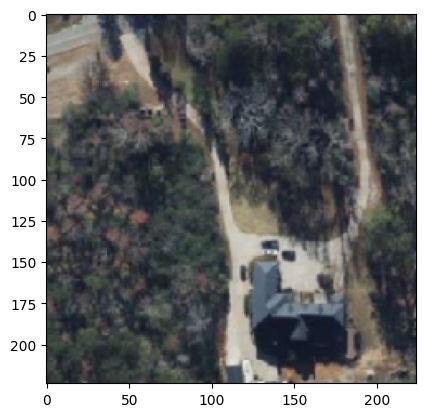

In [13]:
for image, mask, path in valid_dataloader:
    print(path)
    plt.imshow(image[1].permute(1,2,0).numpy())
    break

torch.Size([16, 224, 224])


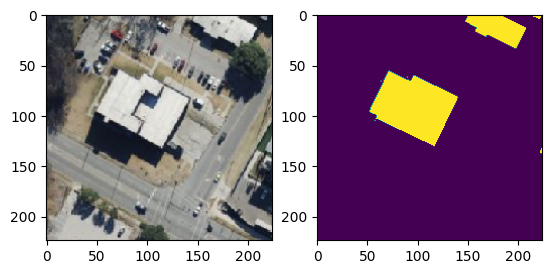

In [15]:
for img, mask, path in train_dataloader:
    print(mask.shape)
    plt.subplot(1,2,1)
    plt.imshow(img[0].permute(1,2,0))

    plt.subplot(1,2,2)
    plt.imshow(mask[0] * 255)
    break

## Define Model

## Model Train

In [16]:
#PyTorch
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [17]:
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=[0.25, 0.75], size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha)
        self.size_average = size_average

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha[1] * (1 - pt) ** self.gamma * BCE_loss
        if self.size_average:
            return F_loss.mean()
        else:
            return F_loss.sum()


In [19]:
model = model(classes=2,
                encoder_name=model_name[0],
                encoder_weights=model_name[1],
               ).to(device)

In [20]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)

def criterion(pred, ground_truth, loss_func):
    bce_loss = torch.nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    tversky_loss = TverskyLoss()
    focal_loss = FocalLoss()
    
    bce_values = bce_loss(pred, ground_truth)
    dice_value = dice_loss(pred, ground_truth)
    tversky_value = tversky_loss(pred, ground_truth)
    focal_values = focal_loss(pred, ground_truth)
    
    if loss_func[0][0] == "DICE": loss_value_1 = dice_value * loss_func[0][1]         # DICE
    elif loss_func[0][0] == "BCE": loss_value_1 = bce_values * loss_func[0][1]        # BCE
    elif loss_func[0][0] == "TVERSKY": loss_value_1 = tversky_value * loss_func[0][1] # tversky

    if loss_func[1][0] == "FOCAL": loss_value_2 = focal_values * loss_func[1][1]      # FOCAL

    return loss_value_1 + loss_value_2

if optimizer_name == "RAdam": optimizer = optim.RAdam(model.parameters(), lr=0.001)
elif optimizer_name == "adam": optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer, T_max=30)

Let's use 4 GPUs!


In [21]:
small_transform  = A.Compose([
                    A.RandomCrop(96, 96),
                    A.HorizontalFlip(p = 0.5),
                    A.OneOf([
                            A.OpticalDistortion(p = 0.5),
                            A.GaussNoise(p = 0.5),
                    ], p = 0.5),
                    A.ColorJitter(p = 0.5),
                    ToTensorV2()
                    ])

In [ ]:
if torch.cuda.device_count() > 1: model.module.load_state_dict(torch.load("./best_se_resnext101_32x4d_pretrained_1024_1024_89.34.pt")['model_state_dict'])
else: model.load_state_dict(torch.load("./best_se_resnext101_32x4d_pretrained_1024_1024_89.34.pt")['model_state_dict'])

In [ ]:
epochs = 100
stop_iter = 20

for epoch in range(epochs):
    if scheduler != 'None':
        scheduler.step(epoch)

    train_total_loss = 0.0
    train_total_count = 0
    train_total_data = 0

    big_dice_score = 0.0
    small_dice_score = 0.0

    val_total_loss = 0.0
    val_total_count = 0
    val_total_data = 0
    
    start_time = time.time()
    model.train()

    with tqdm(train_dataloader,desc='Train',unit='batch') as tepoch:
        for index, (images, masks) in enumerate(tepoch):
            
            small_images = []
            small_masks = []
            for _ in range(6):
                for image, mask in zip (images, masks):
                    augmented = small_transform(image=image.permute(1,2,0).numpy(), mask=mask.numpy())
                    small_images.append(augmented['image'])
                    small_masks.append(augmented['mask'])

            small_images = torch.stack(small_images)
            small_masks = torch.stack(small_masks)

            images = images.float().to(device)
            masks = masks.float().to(device)
            small_images = small_images.float().to(device)
            small_masks = small_masks.float().to(device)

            optimizer.zero_grad()

            outputs = model(images).mean(axis = 1)
            outputs_mask = torch.sigmoid(outputs).cpu().detach().numpy()
            outputs_mask = (outputs_mask > threshold).astype(np.uint8) # Threshold = 0.35  

            small_outputs = model(small_images).mean(axis = 1)
            small_outputs_mask = torch.sigmoid(small_outputs).cpu().detach().numpy()
            small_outputs_mask = (small_outputs_mask > threshold).astype(np.uint8) # Threshold = 0.35  

            dice = dice_score(outputs_mask, masks.cpu().detach().numpy())
            small_dice = dice_score(small_outputs_mask, small_masks.cpu().detach().numpy())

            loss = criterion(outputs, masks, loss_func)
            loss2 = criterion(small_outputs, small_masks, loss_func)

            loss = (loss.sum() + loss2.sum())/2
            loss.backward()
            optimizer.step()

            train_total_loss += (loss.item() + loss2.item())/2
            train_total_count += (dice + small_dice)/2

            small_dice_score += small_dice
            big_dice_score += dice

            tepoch.set_postfix(loss=train_total_loss/(index+1), dice = train_total_count/(index+1), dice_small = small_dice_score/(index+1), dice_big = big_dice_score/(index+1))
            
            
    train_total_loss /= index
    train_accuracy = train_total_count / index * 100
    print(f"Loss: {train_total_loss:.4f}\t\tacc: {train_accuracy}")
    print(f"Loss: {train_total_loss:.4f}")
  
    # check validation dataset
    start_time = time.time()
    model.eval()
    small_dice_score = 0.0
    big_dice_score =  0.0

    with tqdm(valid_dataloader,desc='Validation',unit='batch') as tepoch:
        for index, (images, masks) in enumerate(tepoch):
            
            images = images.float().to(device)
            masks = masks.float().to(device)

            with torch.no_grad():

                outputs = model(images).mean(axis = 1)
                outputs_mask = torch.sigmoid(outputs).cpu().detach().numpy()
                outputs_mask = (outputs_mask > threshold).astype(np.uint8) # Threshold = 0.35  
                
                dice = dice_score(outputs_mask, masks.cpu().detach().numpy())

                loss = criterion(outputs, masks, loss_func)

                val_total_loss += loss.item()
                val_total_count += dice                

                tepoch.set_postfix(loss=val_total_loss/(index+1), dice = val_total_count/(index+1))

    val_total_loss /= index
    val_accuracy = val_total_count / index * 100
    print(f"Loss: {val_total_loss:.4f}\t\tacc: {val_accuracy}")

    scheduler.step(epoch)
    
    if epoch == 0:
        best_loss = val_total_loss
        best_epoch = epoch
        best_acc = val_accuracy
        save_file = "best.pt"
        
        torch.save({'model_state_dict':model.module.state_dict() if torch.cuda.device_count() > 1 else model.state_dict(),
                        'epoch' : epoch,
                        'optimizer_sate_dict':optimizer.state_dict(),
                        'best_loss':best_loss,
                        'learning_rate':optimizer.state_dict()['param_groups'][0]['lr'],
                        'scheduler':scheduler}, save_file)
        
        stop_count = 0
    else:
        if best_acc < val_accuracy:
            best_loss = val_total_loss 
            best_acc = val_accuracy
            best_epoch = epoch
            save_file = "best.pt"
            stop_count = 0
            torch.save({'model_state_dict':model.module.state_dict() if torch.cuda.device_count() > 1 else model.state_dict(),
                        'epoch' : epoch,
                        'optimizer_sate_dict':optimizer.state_dict(),
                        'best_loss':best_loss,
                        'learning_rate':optimizer.state_dict()['param_groups'][0]['lr'],
                        'scheduler':scheduler}, save_file)
            print(f"IMPROVE ACCURACY {val_accuracy:.4f}")
        else:
            stop_count += 1
    
    
    print(f"BEST ACCURACY {best_acc:.4f} and Count = {stop_count} and Best_Epoch = {best_epoch}")    
    if stop_count > stop_iter:
        print('Early Stopping')
        break
    
    print('=' * 30, epoch)

print('=' * 30)

## Inference

In [22]:
test_dataset = SatelliteDataset(csv_file='/home/eslab/nyh/test.csv', mode = None, transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

Let's use 4 GPUs!


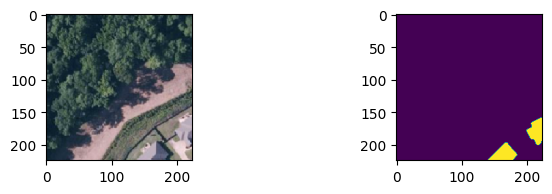

In [23]:
model = smp.UnetPlusPlus
model = model(classes=2,
                encoder_name=model_name[0],
                encoder_weights=model_name[1],
               ).to(device)

model.load_state_dict(torch.load("./best.pt")['model_state_dict'])

if torch.cuda.device_count() > 1:
  model = nn.DataParallel(model)

for i, img in enumerate(test_dataloader):
    i = 1
    output = model(img.float().to(device))
    outputs_mask = torch.sigmoid(output).cpu().detach().numpy()
    outputs_mask = (outputs_mask > 0.6).astype(np.uint8) # Threshold = 0.35
    plt.subplot(1,3,1)
    
    img_np = img[i].permute(1,2,0).numpy()
    img_min = np.min(img_np)
    img_max = np.max(img_np)

    img_scaled = ((img_np - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    plt.imshow(img_scaled)    
    plt.subplot(1,3,3)
    plt.imshow(outputs_mask[i].mean(0)) 

    break

In [25]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs = model(images).mean(axis = 1).unsqueeze(1)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > threshold).astype(np.uint8) # Threshold = 0.35
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

  0%|          | 0/948 [00:00<?, ?it/s]

100%|██████████| 948/948 [08:47<00:00,  1.80it/s]


In [27]:
submit = pd.read_csv('/home/eslab/nyh/sample_submission.csv')

submit['mask_rle'] = result
submit.to_csv('./result_csv/result.csv', index=False)

## 경계 개선 네트워크 사용

100%|██████████| 948/948 [21:45<00:00,  1.38s/it]


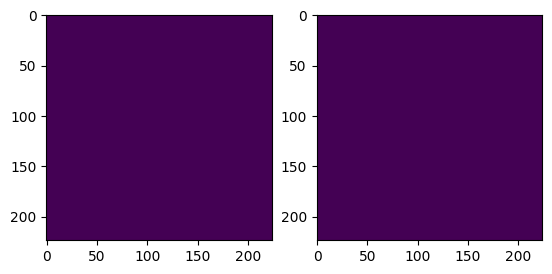

In [27]:
import torchvision.ops
# model = smp.Unet
# model = model(classes=2,
#                 encoder_name="timm-efficientnet-b2",
#                 encoder_weights="noisy-student"
#                ).to(device)

model = smp.UnetPlusPlus(classes=2,
                encoder_name="timm-efficientnet-b4",
                encoder_weights="noisy-student"
               ).to(device)

model2 = smp.UnetPlusPlus(classes=2,
                encoder_name="se_resnext50_32x4d",
                encoder_weights="imagenet",
                in_channels=4
               ).to(device)

model.load_state_dict(torch.load("./best_eff-b4_val_86.9483.pt")['model_state_dict'])
model2.load_state_dict(torch.load("./best_boundry_plus_0.14.pt")['model_state_dict'])
model = nn.DataParallel(model).to(device)
model2 = nn.DataParallel(model2).to(device)

img_crop = 64

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images).mean(axis = 1).unsqueeze(1)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > threshold).astype(np.uint8) # Threshold = 0.35

        crop_32_input, crop_32_gt, crop_32_gt_info = [], [], []
        for i, img in enumerate(masks):
            dst = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))) # 모폴로지 팽창 연산
            diff_clamped = torch.clamp(torch.Tensor(dst)- torch.Tensor(img), min=0, max=1) # 팽창 - 원본 => 경계
            indices = torch.where(diff_clamped == 1) # [Row, Col]
            # indices = torch.where(torch.Tensor(img) == 1) # [Row, Col]
            xx, yy = torch.clamp(indices[0] - img_crop//2, min=0, max=224-img_crop), torch.clamp(indices[1] - img_crop//2, min=0, max=224-img_crop)

            if xx.shape == torch.Tensor([]).shape: continue
            boundary_mask = [torch.stack([x, y, x+img_crop, y+img_crop]) for x, y in zip(xx, yy)]
            boundary_mask = torch.stack(boundary_mask)
            boundary_mask_output = torchvision.ops.nms(boundary_mask[:, :4].float(), torch.ones(boundary_mask.shape[0]), 0.3)

            # bn_idx = boundary_mask[boundary_mask_output]
            for x, y, _, _ in  boundary_mask[boundary_mask_output]:
                crop_32_input.append(torch.cat([images[i, :, x:x+img_crop, y:y+img_crop], torch.Tensor(masks[i, x:x+img_crop, y:y+img_crop].reshape(1, img_crop, img_crop)).to(device)], axis = 0)) # 입력 이미지 차원 [(B+num), 4, 32, 32]
                # crop_32_gt.append(masks[i, x:x+img_crop, y:y+img_crop]) # 정답 차원 [(B+num), 32,32]
                crop_32_gt_info.append([i,x,y])

        if crop_32_input.__len__() == 0: continue
        crop_32_input = torch.stack(crop_32_input)
        # crop_32_gt = torch.stack(crop_32_gt)

        crop_32_input = crop_32_input.to(device)
    
        pred = model2(crop_32_input).mean(1)
        pred_32_mask = torch.sigmoid(pred).cpu().detach().numpy()
        pred_32_mask = (pred_32_mask > threshold).astype(np.uint8)

        plt.subplot(1,2,1)
        plt.imshow(masks[0])

        for (batch_num_idx, idx_x, idx_y), pred_32_mask_one in zip(crop_32_gt_info, pred_32_mask):
            masks[batch_num_idx, idx_x:idx_x+img_crop, idx_y:idx_y+img_crop] = pred_32_mask_one

        plt.subplot(1,2,2)
        plt.imshow(masks[0])
        
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

In [28]:
submit = pd.read_csv('/home/eslab/nyh/sample_submission.csv')

submit['mask_rle'] = result
submit.to_csv('./Calibration_timm_efficientnet_b4_86.948.csv', index=False)

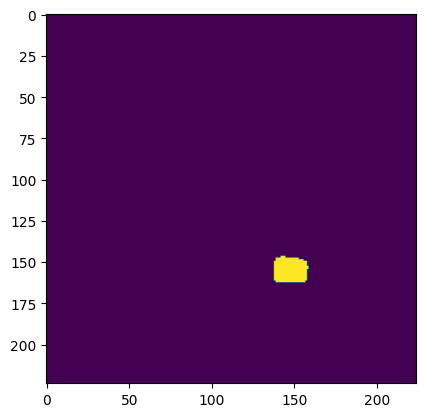

In [34]:
plt.imshow(masks[7])

## Submission

In [30]:
# submit1 = pd.read_csv('./result_csv/resnext101_32x4d_40epoch_87_1403_제출시_81.8.csv') # 40 epoch => 81.7
# submit2 = pd.read_csv('./result_csv/se_resnext101_32x4d_87.03_제출시_81.7.csv') # 40 epoch => 81.7
# submit3 = pd.read_csv('./result_csv/192_resnext101_32x4d_val_87.91.csv')          # 87.87 , X    81.5
# submit4 = pd.read_csv('./result_csv/se_ResNext50_32x4d_val:86.6064_제출시_80.89.csv') # 80.89
# submit5 = pd.read_csv('./result_csv/timm_efficientnet_b4_val_86.9_제출모름.csv') # 50 epoch => 81.8  
# submit6 = pd.read_csv('./result_csv/timm_efficientnet_b3_plus_val_87.28.csv') # 40 epoch => 81.7
# submit7 = pd.read_csv('./result_csv/timm_efficientnet_b2_val_86.4413_제출시_80.5.csv') # 50 epoch => 81.8

In [9]:
submit1 = pd.read_csv('./Calibration_csv/Calibration_192x192_se_resnext101_32x4d.csv') # 40 epoch => 81.7
submit2 = pd.read_csv('./Calibration_csv/Calibration_se_resnext50_32x4d.csv') # 40 epoch => 81.7
submit3 = pd.read_csv('./Calibration_csv/Calibration_se_resnext101_32x4d_40_epoch_81.7.csv')          # 87.87 , X    81.5
submit4 = pd.read_csv('./Calibration_csv/Calibration_se_resnext101_32x4d_50_epoch_81.8.csv') # 80.89
submit5 = pd.read_csv('./Calibration_csv/Calibration_timm_efficientnet_b2_80.5.csv') # 50 epoch => 81.8  
submit6 = pd.read_csv('./Calibration_csv/Calibration_timm_efficientnet_b3_87.28.csv') # 40 epoch => 81.7
submit7 = pd.read_csv('./Calibration_csv/Calibration_timm_efficientnet_b4_86.948.csv') # 50 epoch => 81.8

In [10]:
submit = pd.read_csv('./sample_submission.csv')
result = []
for a,b,c,d,e,f,g in zip(submit1['mask_rle'], submit2['mask_rle'], submit3['mask_rle'], submit4['mask_rle'], submit5['mask_rle'], submit6['mask_rle'], submit7['mask_rle']):
    mask_a = rle_decode(a, (224, 224))
    mask_b = rle_decode(b, (224, 224))
    mask_c = rle_decode(c, (224, 224))
    mask_d = rle_decode(d, (224, 224))
    mask_e = rle_decode(e, (224, 224))
    mask_f = rle_decode(f, (224, 224))
    mask_g = rle_decode(g, (224, 224))

    mask_sum = mask_a + mask_b + mask_c + mask_d + mask_e + mask_f + mask_g
    mask_sum = (mask_sum>3).astype(np.uint8)

    mask_rle = rle_encode(mask_sum)
    if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
        result.append(-1)
    else: result.append(mask_rle)
    
    
submit['mask_rle'] = result

In [11]:
submit = pd.read_csv('/home/eslab/nyh/sample_submission.csv')

submit['mask_rle'] = result
submit.to_csv('./Ensemble_7_Calibration_|se_resnext101_50|_|40|_|se_resnext101_192x192|_|se_resnext50|_effi_b4_b3_b2.csv', index=False)

In [ ]:
# submit.to_csv('./Enesemble_5_|se_resnext101_32x4d_50ep_40ep_se_resnext50_eff_b4_b3_0727_02.csv', index=False)